In [2]:
%pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.10/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [79]:
filename = 'results/simulation_results_all.csv'
df = pd.read_csv(filename)

In [97]:
SETTINGS = ['num_nodes', 'p', 'noise_scale']
df.columns

Index(['num_nodes', 'p', 'noise_scale', 'rank_correl', 'wealth gini',
       'gini- directly connected', 'gini- not directly connected',
       'gini- weakly connected', 'gini- not weakly connected',
       'gini- income-wealth match', 'gini- no income wealth match'],
      dtype='object')

In [81]:
def correlation_heatmap():
    # Step 2: Compute the correlation matrix
    corr_matrix = df.corr()

    # Step 3: Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.show()

In [83]:
def facet_grid(feature):
    # Create the facet grid with line plots
    g = sns.FacetGrid(df, col="p", hue="noise_scale", col_wrap=3, height=4, aspect=1.5)
    g = g.map(sns.lineplot, "num_nodes", feature, marker="o", errorbar=None)

    # Calculate means for each combination of 'num_nodes', 'noise_scale', and 'p'
    df_means = df.groupby(['num_nodes', 'noise_scale', 'p'], as_index=False).mean()

    # Overlay scatter plot with mean values
    for ax in g.axes.flat:
        title = ax.get_title()
        prob_connected = float(title.split('=')[-1].strip())
        subset = df_means[df_means['p'] == prob_connected]
        sns.scatterplot(data=subset, x="num_nodes", y=feature, hue="noise_scale", ax=ax, s=100, legend=False, marker="o", edgecolor='w', linewidth=1)

    # Set axis labels
    g.set_axis_labels("Number of Nodes", feature)
    
    # Set titles for each subplot
    g.set_titles("Probability Connected: {col_name}")
    
    # Adjust legend properties
    g.add_legend(title='Noise Scale')
    
    # Set overall title for the facet grid
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Effect of Num Nodes and Noise Scale on {feature}', fontsize=16)
    
    # Show the plot
    plt.show()

In [89]:
def facet_grid_with_hist(feature, kind='kde'):
    g = sns.FacetGrid(df, col="p", hue="noise_scale", col_wrap=3, height=4, aspect=1.5)
    
    if kind == 'hist':
        g = g.map(plt.hist, feature, bins=10, alpha=0.7)
    elif kind == 'kde':
        g = g.map(sns.kdeplot, feature)
    
    # Set axis labels
    g.set_axis_labels(feature, "Count")
    
    # Set titles for each subplot
    g.set_titles("Probability Connected: {col_name}")
    
    # Adjust legend properties
    g.add_legend(title='Noise Scale')
    
    # Set overall title for the facet grid
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Distribution of {feature} by Num Nodes and Noise Scale', fontsize=16)
    
    # Show the plot
    plt.show()

In [92]:
def facet_grid_with_count(category):
    g = sns.FacetGrid(df, col="p", hue="noise_scale", col_wrap=3, height=4, aspect=1.5)
    g = g.map(sns.countplot, category)
    
    # Set axis labels
    g.set_axis_labels(category, "Count")
    
    # Set titles for each subplot
    g.set_titles("Probability Connected: {col_name}")
    
    # Adjust legend properties
    g.add_legend(title='Noise Scale')
    
    # Set overall title for the facet grid
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Count of {category} by Num Nodes and Noise Scale', fontsize=16)
    
    # Show the plot
    plt.show()

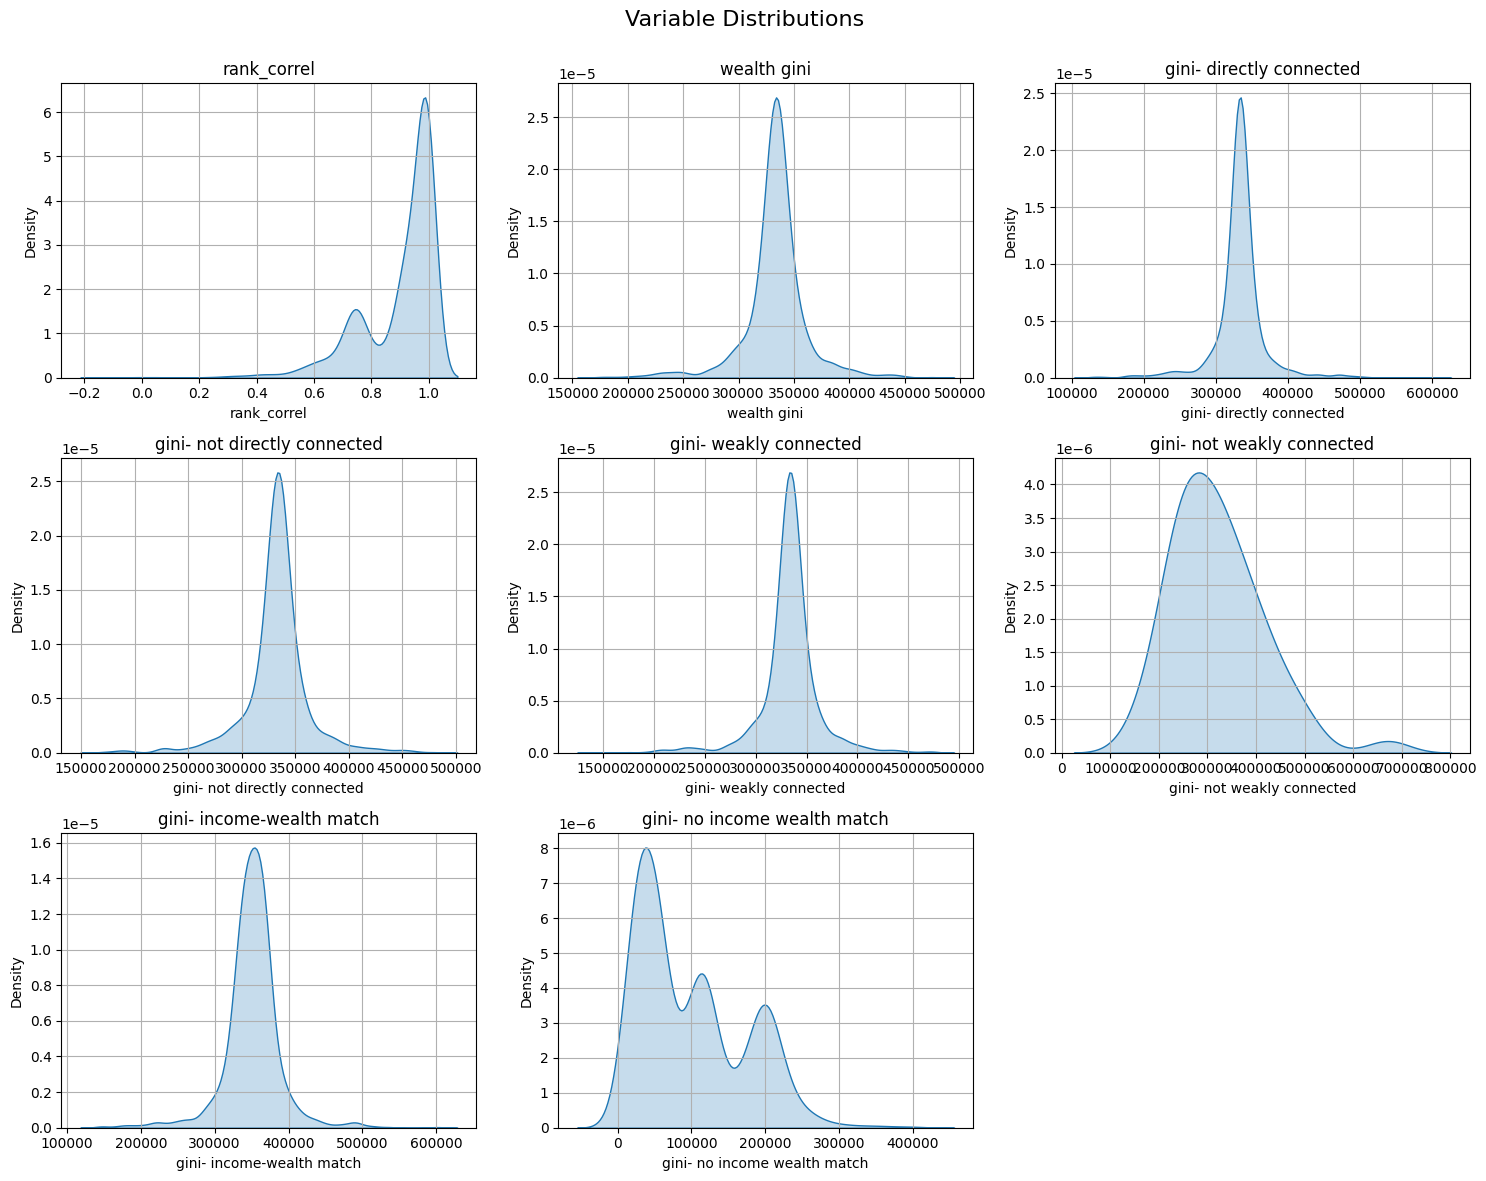

In [148]:
def plot_overall_distributions():
    num_cols = df.select_dtypes(include='float64').shape[1]
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
    axes = axes.flatten()

    plot_index = 0
    for column in df.columns:
        if column not in SETTINGS:
            plot_distribution(df[column], ax=axes[plot_index])
            plot_index += 1
            if plot_index >= num_cols:
                break

    # Remove any unused axes
    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle('Variable Distributions', fontsize=16)
    plt.show()

def plot_distribution(data, ax=None, kind='kde'):
    if ax is None:
        plt.figure(figsize=(8, 6))
    else:
        plt.sca(ax)
    
    if kind == 'hist':
        sns.histplot(data.dropna(), bins=10, kde=False, stat='density')
    elif kind == 'kde':
        sns.kdeplot(data.dropna(), fill=True)
    
    ax.set_title(f'{data.name}')
    ax.set_xlabel(data.name)
    ax.set_ylabel('Density' if kind == 'kde' else 'Count')
    ax.grid(True)

plot_overall_distributions()

In [159]:

def plot_distributions_by_var(var, var_name, type='kde'):
    # Melt the dataframe to have variable and value columns for plotting
    df_melted = df.melt(id_vars=SETTINGS, 
                        var_name='variable', value_name='value')

    # Filter out columns in SETTINGS
    df_melted = df_melted[~df_melted['variable'].isin(SETTINGS)]

    # Create a FacetGrid for KDE plots
    g = sns.FacetGrid(df_melted, col='variable', hue=var, 
                      col_wrap=3, height=4, aspect=1.5, sharex=False, sharey=False)

    # Map KDE plots to each facet
    if type == 'hist':
        g.map(sns.histplot, 'value', bins=10)
    else:
        g.map(sns.kdeplot, 'value', fill=False)

    # Add legend and titles
    g.add_legend(title=var)
    g.set_axis_labels('Value', 'Density')
    g.fig.suptitle(f'KDE Distributions by {var_name}', y=1.02)

    # Adjust layout
    plt.tight_layout()
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


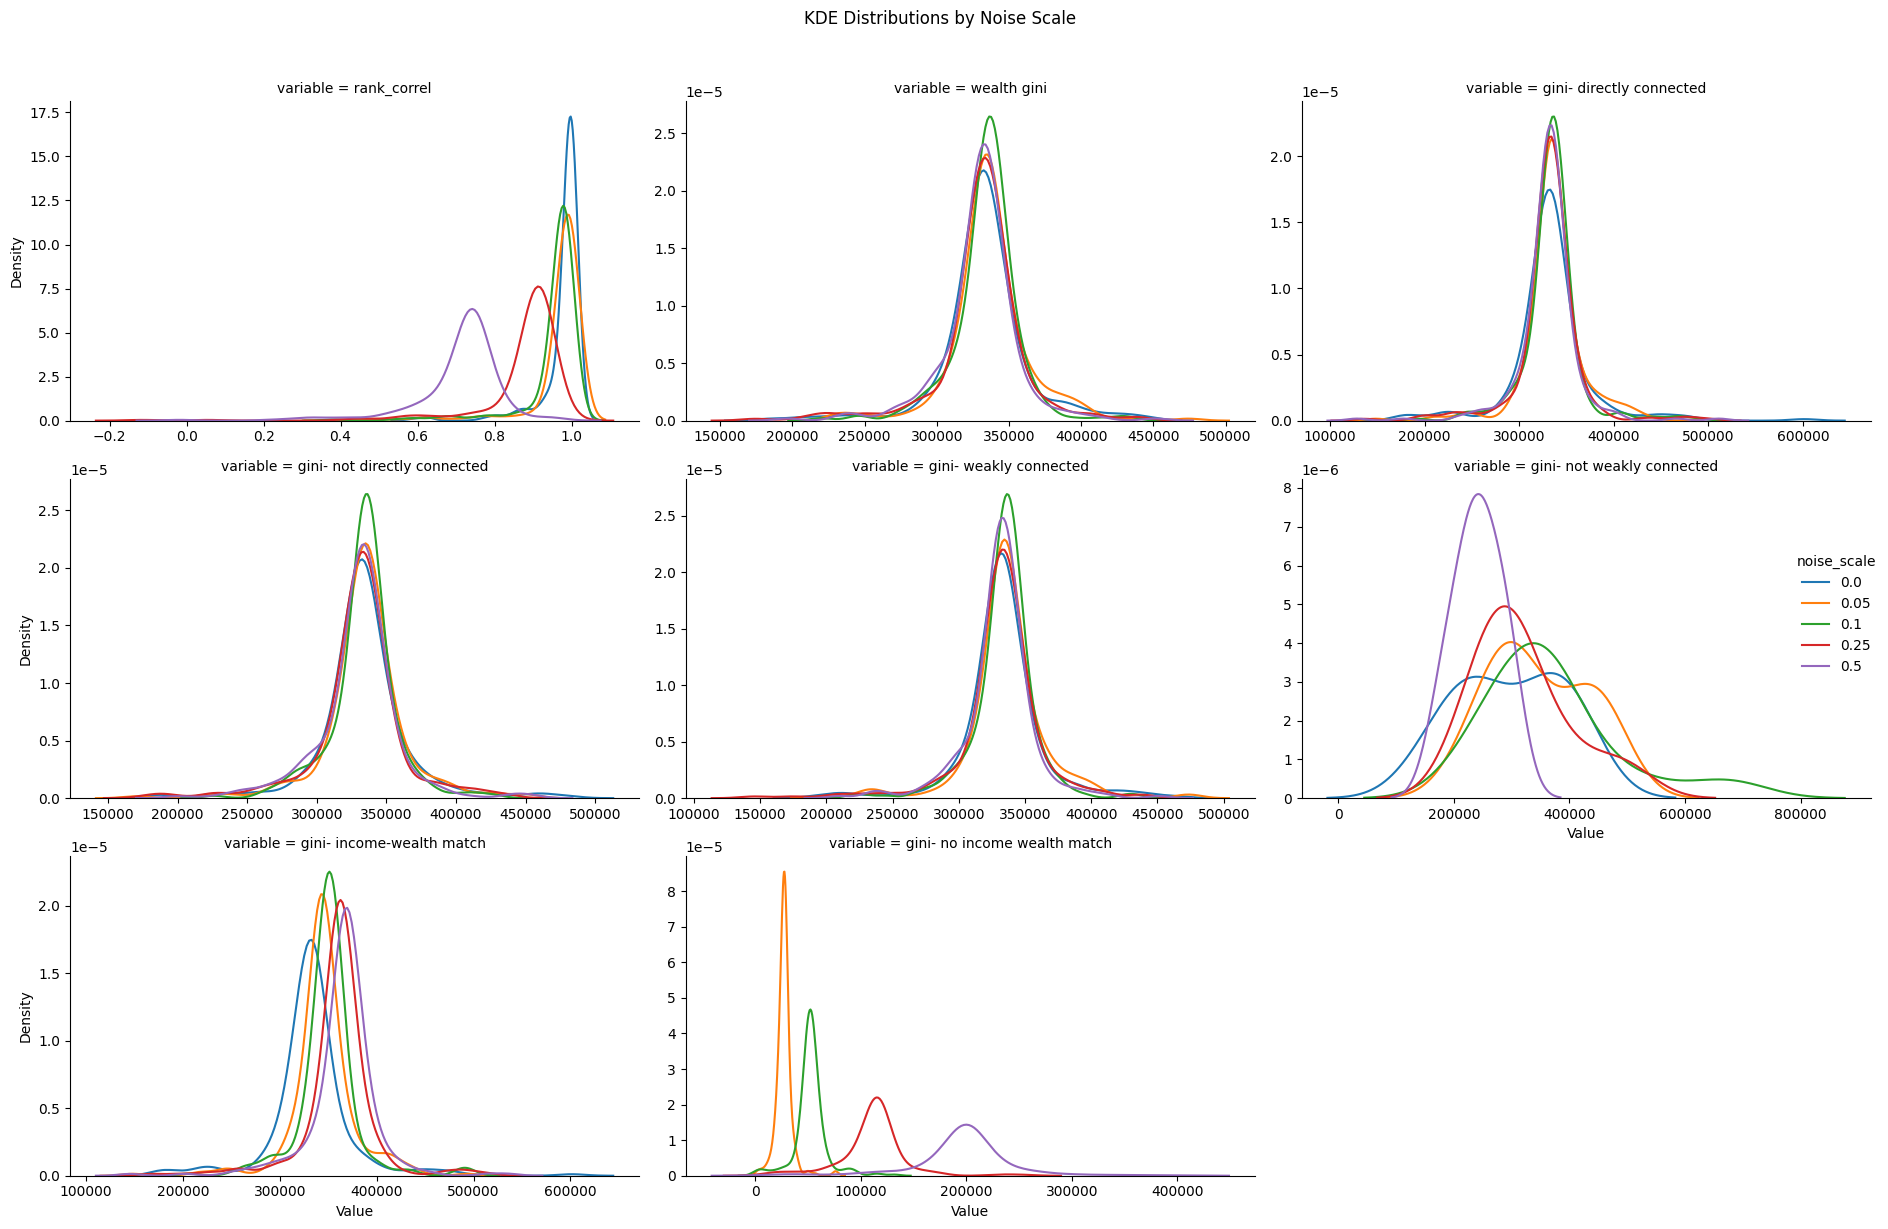

In [161]:
plot_distributions_by_var('noise_scale', "Noise Scale")

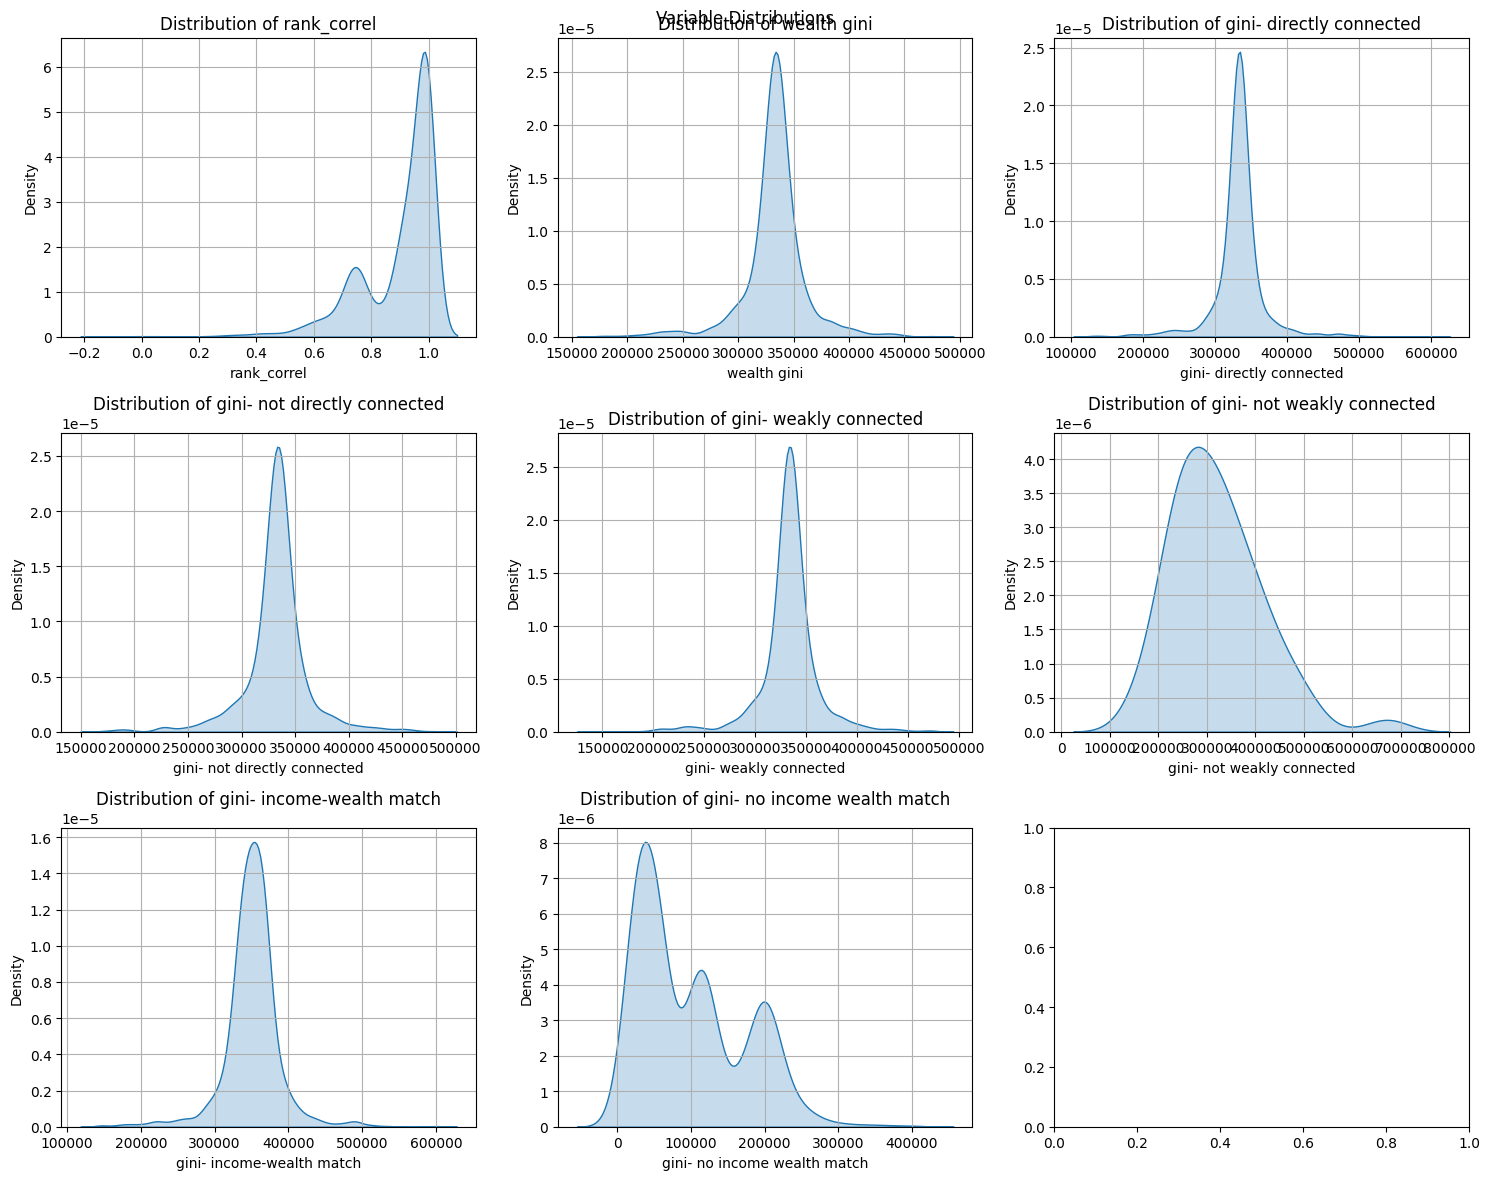

In [145]:
facet_grid_with_hist(

SyntaxError: incomplete input (3190279147.py, line 1)

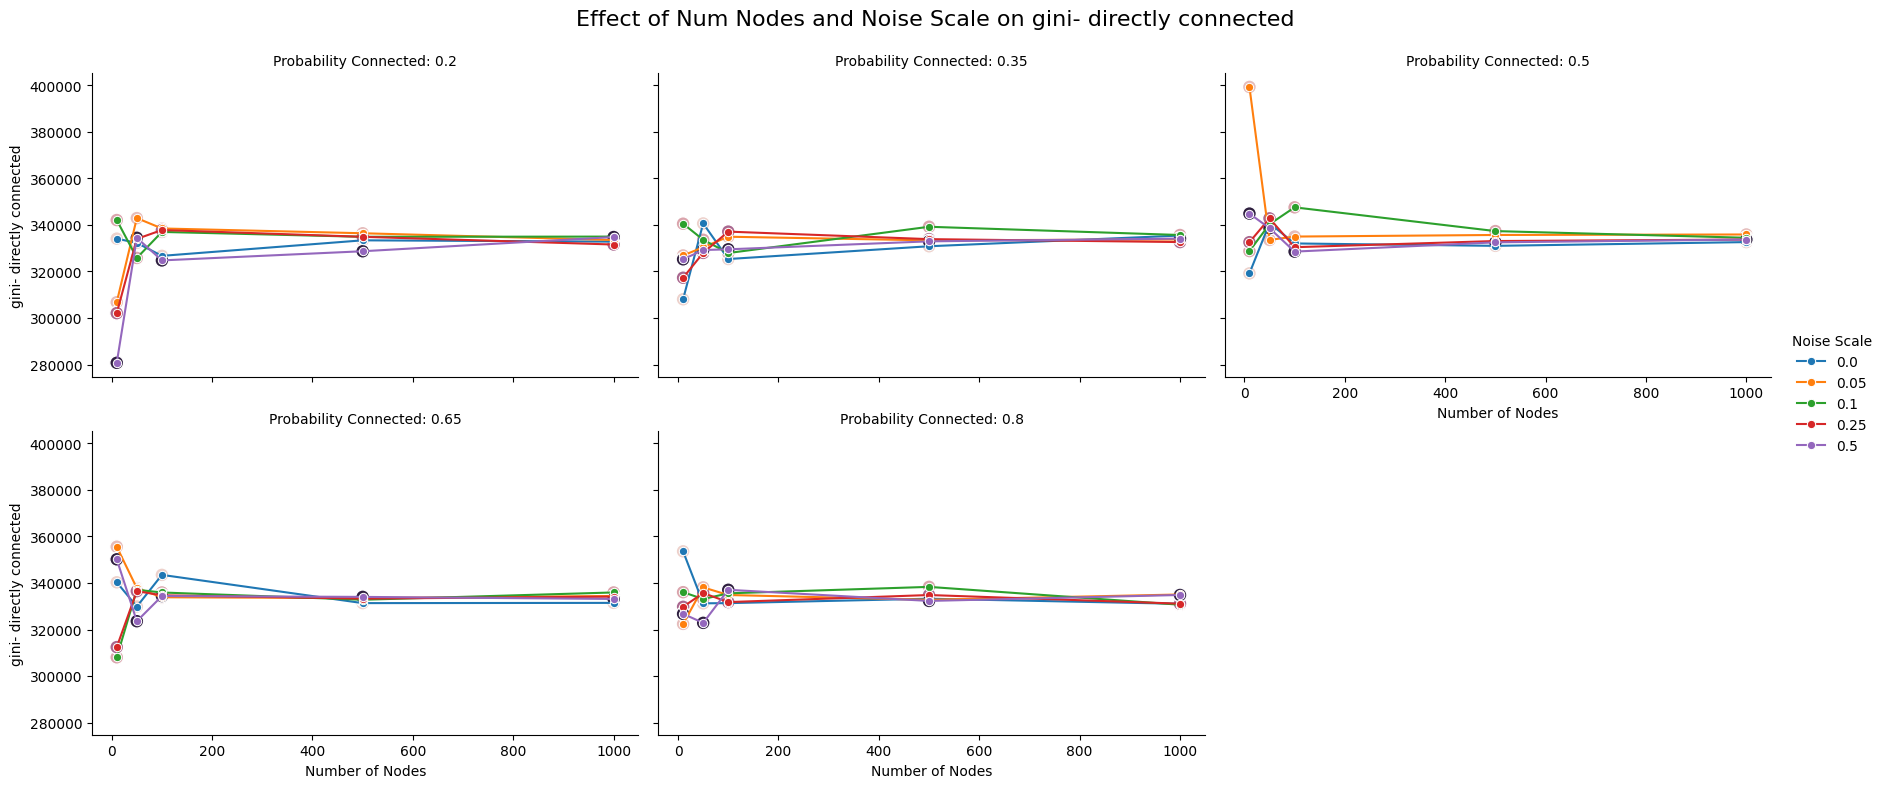

In [84]:
facet_grid("gini- directly connected")

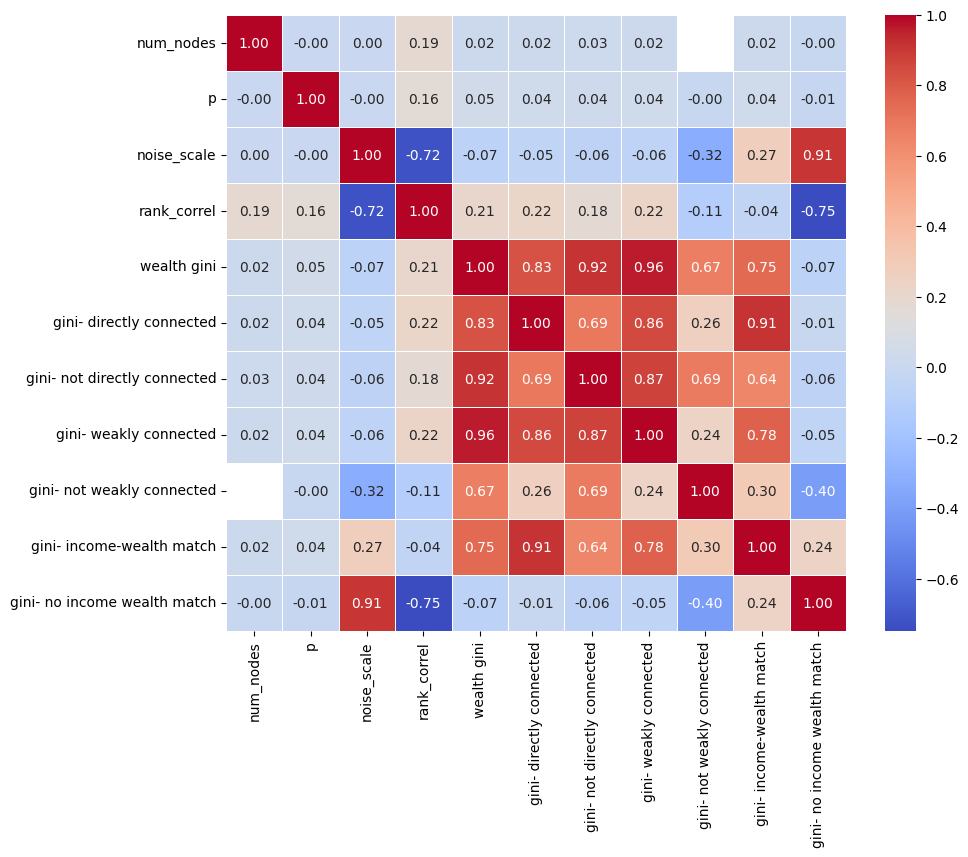

In [85]:
correlation_heatmap()

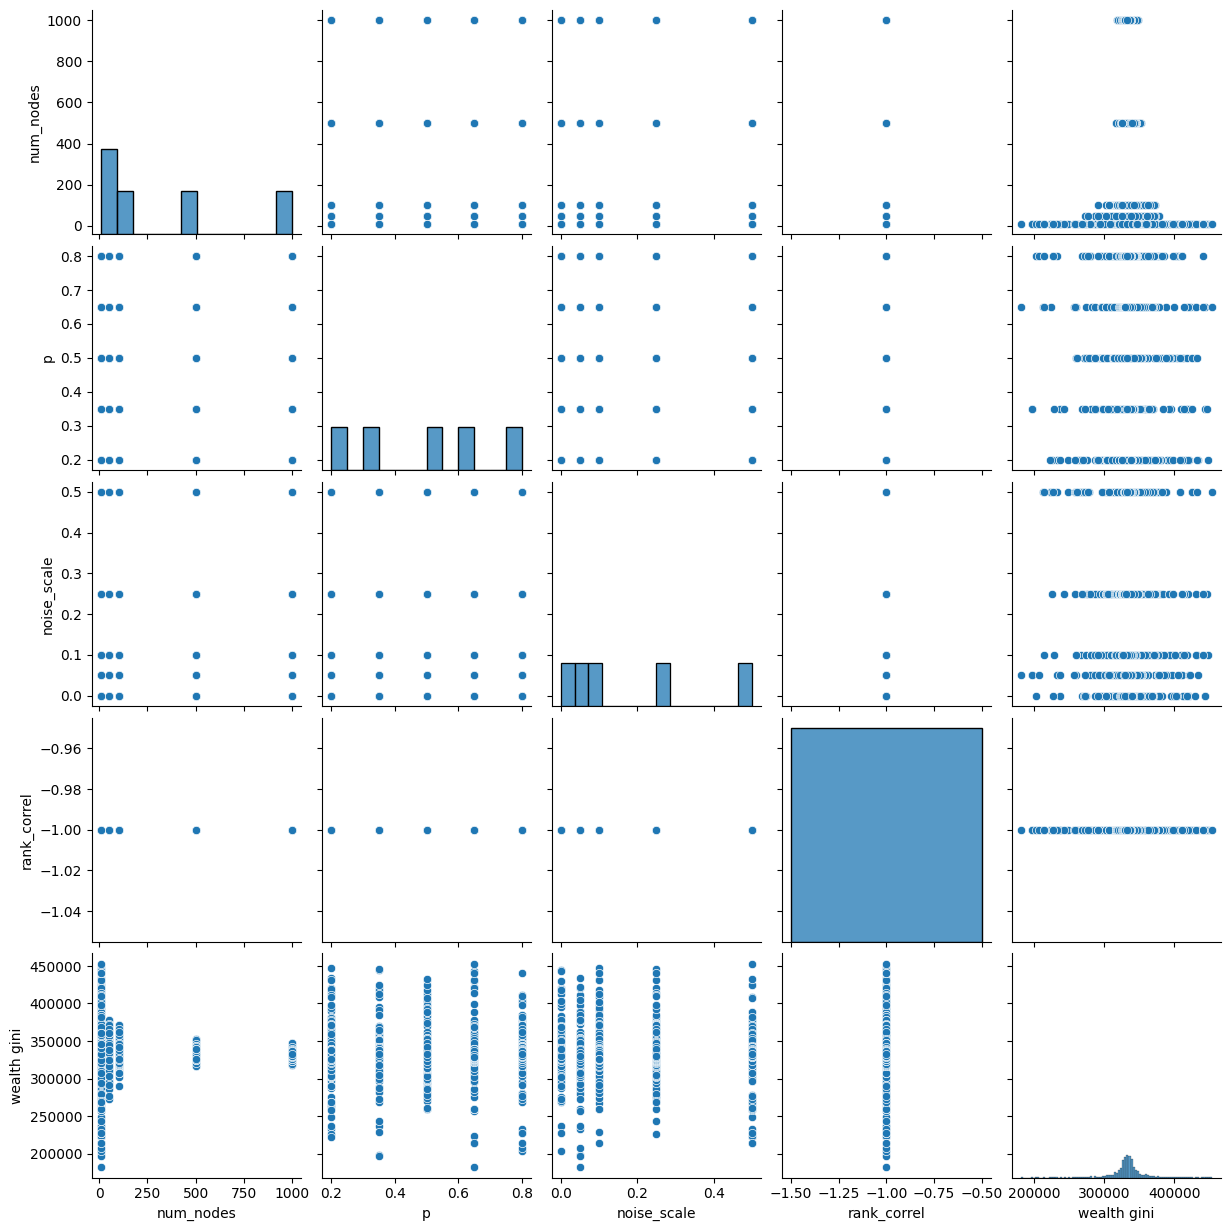

In [16]:
pair_plots()